In [7]:
%matplotlib inline

from hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity
#from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueParser

# Python dependences
import os
import h5py
import numpy as np   # Numpy - Python's numerical library
import matplotlib.pyplot as plt  # Matplotlib - Python's plotting library
from copy import deepcopy   # Python module for copying objects

# Input and Output Tools
# Catalogue and sources 
from hmtk.parsers.catalogue import CsvCatalogueParser   # Reads an earthquake catalogue from CSV
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter  # Writes an earthquake catalogue to CSV
from hmtk.parsers.source_model.nrml04_parser import nrmlSourceModelParser  # Imports a source model from XML

# Plotting tools
from hmtk.plotting.mapping import HMTKBaseMap
from hmtk.plotting.seismicity.completeness import plot_stepp_1972
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_scatter
from hmtk.plotting.seismicity.catalogue_plots import plot_depth_histogram
from hmtk.plotting.seismicity.catalogue_plots import plot_magnitude_time_density
from hmtk.plotting.seismicity.max_magnitude.cumulative_moment import plot_cumulative_moment 
from hmtk.plotting.seismicity.catalogue_plots import (plot_observed_recurrence, 
                                                      get_completeness_adjusted_table,
                                                      _get_catalogue_bin_limits)

# Seismicity tools: Events and declustering methods
from hmtk.seismicity.selector import CatalogueSelector
from hmtk.seismicity.declusterer.dec_afteran import Afteran 
from hmtk.seismicity.declusterer.dec_gardner_knopoff import GardnerKnopoffType1 
from hmtk.seismicity.declusterer.distance_time_windows import (GardnerKnopoffWindow, 
                                                               GruenthalWindow, 
                                                               UhrhammerWindow)

# Completeness tools
from hmtk.seismicity.completeness.comp_stepp_1971 import Stepp1971

# Seismicity tools: Recurrence methods
from hmtk.seismicity.occurrence.aki_maximum_likelihood import AkiMaxLikelihood
from hmtk.seismicity.occurrence.b_maximum_likelihood import BMaxLikelihood
from hmtk.seismicity.occurrence.kijko_smit import KijkoSmit
from hmtk.seismicity.occurrence.weichert import Weichert

# Seismicity tools: Recurrence methods
from hmtk.seismicity.max_magnitude.kijko_sellevol_fixed_b import KijkoSellevolFixedb
from hmtk.seismicity.max_magnitude.kijko_sellevol_bayes import KijkoSellevolBayes
from hmtk.seismicity.max_magnitude.kijko_nonparametric_gaussian import KijkoNonParametricGaussian
from hmtk.seismicity.max_magnitude.cumulative_moment_release import CumulativeMoment 

# Seismicity tools: Smoothed seismicity
from hmtk.seismicity.smoothing.smoothed_seismicity import SmoothedSeismicity 
from hmtk.seismicity.smoothing.kernels.isotropic_gaussian import IsotropicGaussian 

# To build source model
from hmtk.sources.source_model import mtkSourceModel
from hmtk.sources.point_source import mtkPointSource
from openquake.hazardlib.geo.point import Point
from openquake.hazardlib.mfd import TruncatedGRMFD
from openquake.hazardlib.geo.nodalplane import NodalPlane
from openquake.hazardlib.pmf import PMF
#from nrml.models import HypocentralDepth
#nrml.models import HypocentralDepth
print "Everything Imported OK!"

Everything Imported OK!


### Jono's Aussie Catalogue

In [3]:
ifile = "catalogue/AUSTCAT_pref11_DB_main341_hmtk_format.csv"
parser = CsvCatalogueParser(ifile)
catalogue = parser.read_file(start_year=1788, end_year=2010)
# How many events in the catalogue?
print "The catalogue contains %g events" % catalogue.get_number_events()

# What is the geographical extent of the catalogue?
bbox = catalogue.get_bounding_box()
print "Catalogue ranges from %.4f E to %.4f E Longitude and %.4f N to %.4f N Latitude\n" % bbox

The catalogue contains 36792 events
Catalogue ranges from 18.1228 E to 170.9110 E Longitude and -77.0311 N to -0.0530 N Latitude



In [9]:
catalogue.sort_catalogue_chronologically()
index = np.logical_and(catalogue.data["magnitude"] > 1.5, catalogue.data["depth"] >= 0.0) 
catalogue.purge_catalogue(index)
catalogue.get_number_events()

27907

In [10]:
# Copying the catalogue and saving it under a new name "catalogue_clean"
catalogue_clean = deepcopy(catalogue)

# remove nan magnitudes
catalogue_clean.purge_catalogue(index)
catalogue_clean.sort_catalogue_chronologically()
catalogue_clean.data['magnitude']
catalogue_clean.data['year']
catalogue_clean.get_decimal_time()
catalogue_clean.data['longitude']

array([ 145.    ,  138.6   ,  138.6   , ...,  130.7749,  138.3639,
        121.1477])

In [11]:
catalogue_depth_clean = deepcopy(catalogue_clean)
index = catalogue_depth_clean.data['depth']>=0.
catalogue_depth_clean.purge_catalogue(index)
catalogue_clean.get_number_events()

27907

In [12]:
source_model_file = "./zones/Aus_cont_testzone.xml"
parser = nrmlSourceModelParser(source_model_file)

# Parse the seismic sources and save them into a variable called "source_model"
source_model = parser.read_file("Aus Source Model 1") # You need to supply a name for the source model

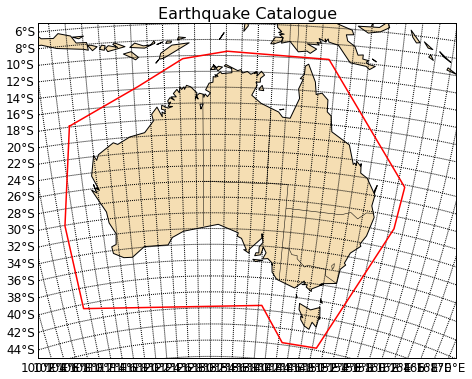

110.2 155.828 -45.567 -10.0
Source ID: 1  Source Name: Continent   Number of Events: 14319


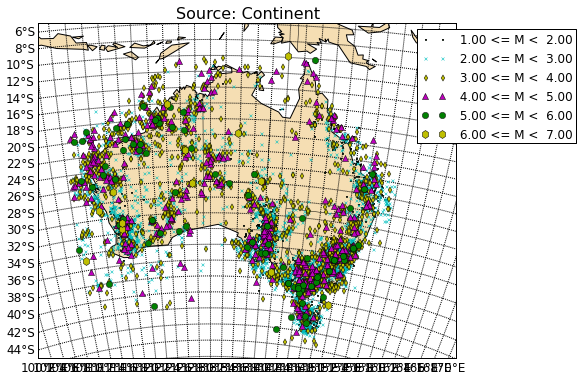

In [13]:
# Map configuration
llon, ulon, llat, ulat = catalogue_clean.get_bounding_box()
#map_config = {'min_lon': np.floor(llon), 'max_lon': np.ceil(ulon),
 #             'min_lat': np.floor(llat), 'max_lat': np.ceil(ulat), 'resolution':'c'}
map_config = {'min_lon': np.floor(100), 'max_lon': np.ceil(160),
              'min_lat': np.floor(-45), 'max_lat': np.ceil(-4), 'resolution':'c'}
# Creating a basemap - input a cconfiguration and (if desired) a title
basemap1 = HMTKBaseMap(map_config, 'Earthquake Catalogue')

# Adding the seismic sources
basemap1.add_source_model(source_model, area_border='r-', border_width=1.5, alpha=0.5)

# Select catalogue from within sourcezone
selector1 = CatalogueSelector(catalogue_depth_clean, create_copy=True)
for source in source_model.sources:
    source.select_catalogue(selector1)
    
    llon, ulon, llat, ulat = source.catalogue.get_bounding_box()
    print llon, ulon, llat, ulat
    # Map the Source
    src_basemap = HMTKBaseMap(map_config, "Source: {:s}".format(source.name))
    print "Source ID: %s  Source Name: %s   Number of Events: %g" % (source.id, source.name,
                                                                     source.catalogue.get_number_events())
    # Add on the catalogue
    src_basemap.add_catalogue(source.catalogue, overlay=False)


2010.0 2.0
1980.0 2.0
1964.0 3.5
1900.0 5.5
1837.0 5.5


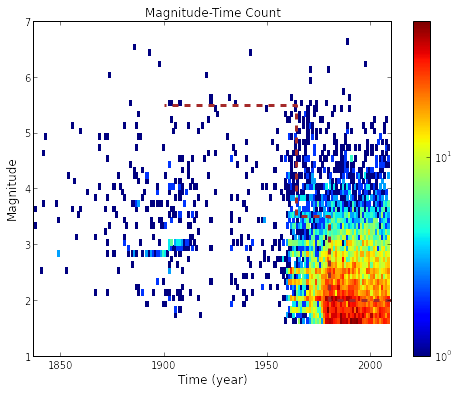

In [48]:
completeness_table_a = np.array([[1980., 2.0],
                                 [1964., 3.5],
                                 [1900., 5.5]])
plot_magnitude_time_density(source.catalogue, 0.1, 1.0,
                            completeness=completeness_table_a)

In [26]:
grid_lims = [110., 160.0, 1., -45.0, -5.0, 1., 0., 50., 50.]
#smoother2 = SmoothedSeismicity(grid_lims2, use_3d=False, bvalue=0.9)
#config = {"Length_Limit": 3.0, "BandWidth": 100.0, "increment":False}
#data = smoother2.run_analysis(catalogue, config, comp_table)

In [19]:
#smoother2.write_to_csv("Australia_JonoCat_v3.csv")
#writer.write_file(catalogue, magnitude_table=comp_table)

In [20]:
from hmtk.parsers.catalogue.csv_catalogue_parser import CsvCatalogueWriter


In [50]:
writer = CsvCatalogueWriter("Australia_Cat_Mgt4p5.csv")
writer.write_file(source.catalogue, magnitude_table=completeness_table_a)

[False False False ..., False False False]
[ True False  True ..., False False False]
[ True  True  True ..., False False False]


In [22]:
import helmstetter_werner_2012 as h_w

In [51]:
config = {"bandwidth": 50,
          "r_min": 1.0E-7, 
          "bvalue": 1.0, "mmin": 4.5,
          "learning_start": 1850, "learning_end": 2003,
          "target_start": 2004, "target_end": 2010}
smoother = h_w.FixedWidthSmoothing(grid_lims, config, source.catalogue, storage_file="Aus1_tmp.hdf5")
smoother._get_catalogue_completeness_weights(completeness_table_a)
smoother.build_catalogue_2_grid_array()
smoother.run_smoothing(config["r_min"], config["bandwidth"])

Building event to grid distance arrays
2016-08-08 16:31:51.243628
Processing ...
0.0 % - 2016-08-08 16:31:51.247681
5.0 % - 2016-08-08 16:31:51.281969
10.0 % - 2016-08-08 16:31:51.301654
15.0 % - 2016-08-08 16:31:51.319033
20.0 % - 2016-08-08 16:31:51.357976
25.0 % - 2016-08-08 16:31:51.396218
30.0 % - 2016-08-08 16:31:51.434706
35.0 % - 2016-08-08 16:31:51.480819
40.0 % - 2016-08-08 16:31:51.518647
45.0 % - 2016-08-08 16:31:51.555142
50.0 % - 2016-08-08 16:31:51.591750
55.0 % - 2016-08-08 16:31:51.628537
60.0 % - 2016-08-08 16:31:51.664037
65.0 % - 2016-08-08 16:31:51.704095
70.0 % - 2016-08-08 16:31:51.742056
75.0 % - 2016-08-08 16:31:51.778639
80.0 % - 2016-08-08 16:31:51.814423
85.0 % - 2016-08-08 16:31:51.850107
90.0 % - 2016-08-08 16:31:51.886199
95.0 % - 2016-08-08 16:31:51.921141
100.0 % - 2016-08-08 16:31:52.157912
done!
0.0 % - 2016-08-08 16:31:52.170561
5.0 % - 2016-08-08 16:31:52.220272
10.0 % - 2016-08-08 16:31:52.266723
15.0 % - 2016-08-08 16:31:52.312864
20.0 % - 2016-08

In [52]:
np.savetxt("Australia_FixedWidth2_50km.csv",
           np.column_stack([smoother.grid, smoother.rates]),
           delimiter=",",
           fmt=["%.4f", "%.4f", "%.8e"],
          header="longitude,latitude,rate" 
          )

In [53]:
config = {"k": 3,
          "r_min": 1.0E-7, 
          "bvalue": 1.0, "mmin": 4.5,
          "learning_start": 1900, "learning_end": 2003,
          "target_start": 2004, "target_end": 2013}

smoother = h_w.HelmstetterEtAl2007(grid_lims, config, source.catalogue, storage_file="Aus1_tmp2.hdf5")

smoother._get_catalogue_completeness_weights(completeness_table_a)
smoother.build_distance_arrays()
smoother.build_catalogue_2_grid_array()
d_i = smoother.optimise_bandwidths()
smoother.run_smoothing(config["r_min"], d_i)
np.savetxt("Australia_Adaptive_K3.csv",
           np.column_stack([smoother.grid, smoother.rates]),
           delimiter=",",
           fmt=["%.4f", "%.4f", "%.8e"],
          header="longitude,latitude,rate" 
          )

0.0 % - 2016-08-08 16:32:04.114989
10.0 % - 2016-08-08 16:32:04.140046
20.0 % - 2016-08-08 16:32:04.164892
30.0 % - 2016-08-08 16:32:04.188743
40.0 % - 2016-08-08 16:32:04.212024
50.0 % - 2016-08-08 16:32:04.236682
60.0 % - 2016-08-08 16:32:04.261182
70.0 % - 2016-08-08 16:32:04.285267
80.0 % - 2016-08-08 16:32:04.308150
90.0 % - 2016-08-08 16:32:04.333694
Building event to grid distance arrays
2016-08-08 16:32:04.433228
Processing ...
0.0 % - 2016-08-08 16:32:04.435544
5.0 % - 2016-08-08 16:32:04.470307
10.0 % - 2016-08-08 16:32:04.505638
15.0 % - 2016-08-08 16:32:04.546987
20.0 % - 2016-08-08 16:32:04.578912
25.0 % - 2016-08-08 16:32:04.609256
30.0 % - 2016-08-08 16:32:04.638736
35.0 % - 2016-08-08 16:32:04.669397
40.0 % - 2016-08-08 16:32:04.698443
45.0 % - 2016-08-08 16:32:04.718981
50.0 % - 2016-08-08 16:32:04.736567
55.0 % - 2016-08-08 16:32:04.764875
60.0 % - 2016-08-08 16:32:04.797301
65.0 % - 2016-08-08 16:32:04.828655
70.0 % - 2016-08-08 16:32:04.859758
75.0 % - 2016-08-08 16

TypeError: __init__() got an unexpected keyword argument 'label'

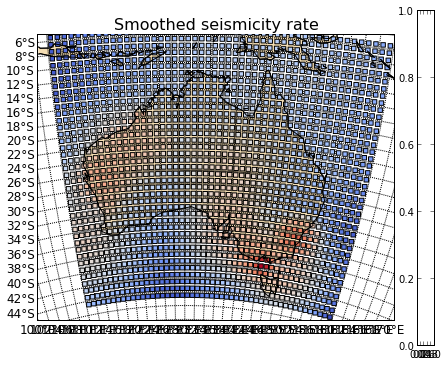

In [54]:
# Creating a basemap - input a cconfiguration and (if desired) a title
basemap1 = HMTKBaseMap(map_config, 'Smoothed seismicity rate')
basemap1.m.drawmeridians(np.arange(llat, ulat, 5))
basemap1.m.drawparallels(np.arange(llon, ulon, 5))
#print smoother.data[:,0]
#print smoother.data[:,1]
# Adding the smoothed grip to the basemap
#sym = (2., 3.,'cx')
x,y = basemap1.m(smoother.grid[:,0], smoother.grid[:,1])
basemap1.m.scatter(x, y, marker = 's', c = np.log10(smoother.rates), cmap = plt.cm.coolwarm, zorder=10)
basemap1.m.drawcoastlines(linewidth=1, zorder=50) # Add coastline on top
#basemap1.m.drawmeridians(np.arange(llat, ulat, 5))
#basemap1.m.drawparallels(np.arange(llon, ulon, 5))
plt.colorbar(label='log10(Smoothed rate per cell)')
#plt.legend()
#basemap1.m.scatter(x, y, marker = 's', c = smoother.data[:,4], cmap = plt.cm.coolwarm, zorder=10)
#basemap1.m.scatter([150],[22], marker='o')
#basemap1.fig.show()

#(smoother.data[0], smoother.data[1])
#basemap1.add_catalogue(catalogue_depth_clean, erlay=False)
plt.savefig('/media/sf_openquake_shared_files/Australia/catalogue/smoothed_%i_%i_2.png' % \
                        (smoothing_config["BandWidth"], smoothing_config["Length_Limit"]))